In [1]:
import  struct
import  cv2
import  numpy       as      np
from    matplotlib  import  pyplot  as  plt
from    Hoda        import  read_hoda_dataset,read_hoda_cdb,__resize_image

import  torch
import  numpy               as      np
import  torch.nn            as      nn
from    torch.utils.data    import  TensorDataset, DataLoader
from    torchinfo           import  summary
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
torch.manual_seed(42)

from helper_functions import plot_loss_curves
from torchmetrics.classification    import Accuracy,F1Score,Precision,ConfusionMatrix
from typing                         import Dict, List, Tuple
from sklearn.metrics                import classification_report
import numpy as np
import torch
from SadigAli import Hoda_SadigAli

/home/ysn/anaconda3/envs/torch113_2/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ysn/anaconda3/envs/torch113_2/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
test_images , Y_test             = read_hoda_dataset(dataset_path='./HODA/Test 20000.cdb' ,images_height=40, images_width=40, one_hot=False, reshape=True)
# X_remaining, Y_remaining    = read_hoda_dataset('./HODA/RemainingSamples.cdb'        ,images_height=40,images_width=40,one_hot=True,reshape=True)

def formizer(numpyarray:np.array):
    len5=len(numpyarray)
    numpyarray=numpyarray/255
    return numpyarray.reshape(len5,40,40)

xtest   =formizer(test_images)
xvxv , yvyv= torch.stack([torch.from_numpy(np.array(i)) for i in xtest]).float() , torch.stack([torch.from_numpy(np.array(i)) for i in Y_test]).long()
xvxv=xvxv.unsqueeze(1)
test_dataset =  torch.utils.data.TensorDataset(xvxv, yvyv)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80000,num_workers=3,shuffle=True)

In [3]:
import seaborn as sns
def eval(model,lossfu,test_dataloader,device):
    model.eval()
    test_loss, test_acc = 0, 0
    metric=Accuracy(task="multiclass", num_classes=10)
    li_metric=[]
    f1 = F1Score(task="multiclass", num_classes=10)
    ls_f1metric=[]
    percision = Precision(task="multiclass", num_classes=10)
    ls_percision=[]
    confmatrx=ConfusionMatrix(task="multiclass", num_classes=10)

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)


            test_pred_logits = model(X).to('cpu')
            y =  y.to('cpu')
            loss = lossfu(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(y))
            li_metric.append(metric(test_pred_labels,y))
            ls_f1metric.append(f1(test_pred_labels,y))
            ls_percision.append(percision(test_pred_labels,y))
    
            print("Accuracy  :",test_acc, '\n')
            print("f1Score   :",sum(ls_f1metric).numpy(), '\n')
            print("loss      :",test_loss             , '\n')
            print("percision :",sum(ls_percision).numpy(),'\n')
            fig, ax = plt.subplots(figsize=(17,4))         # Sample figsize in inches
            fig.suptitle("confusion matrix ")
            sns.heatmap(confmatrx(test_pred_labels,y), annot=True, linewidths=6.5,)
            
            break

## 1 Stochastic gradient-based optimization (SGD)

Accuracy  : 0.9959 

f1Score   : 0.9959 

loss      : 0.019282298162579536 

percision : 0.9959 



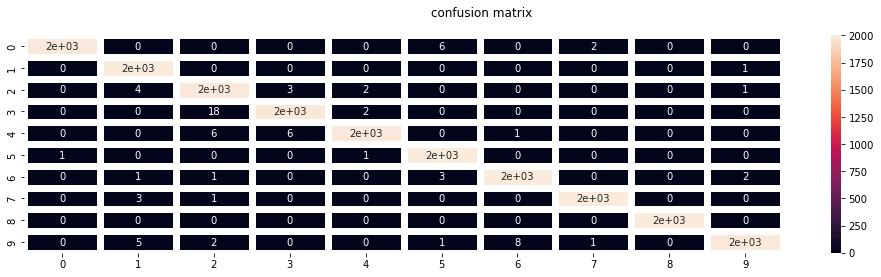

In [4]:
model = Hoda_SadigAli()
model.load_state_dict(torch.load("models/07_Hoda_SadigAli_SGD_20_epochs.pth"))
model.to(device)
eval(model,nn.CrossEntropyLoss(),test_loader,device)

## 3.2 Adaptive delta (Adadelta)

Accuracy  : 0.9959 

f1Score   : 0.9959 

loss      : 0.020605865865945816 

percision : 0.9959 



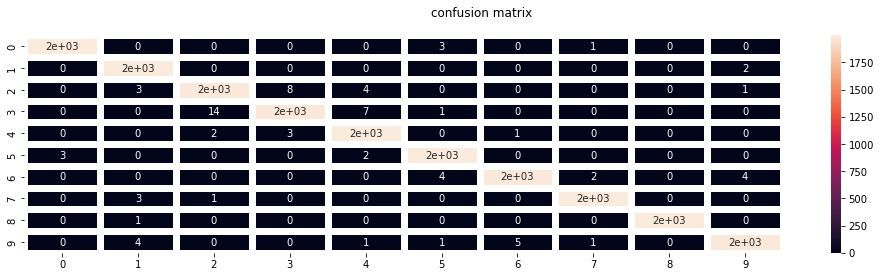

In [5]:
model.load_state_dict(torch.load("models/07_Hoda_SadigAli_adaleta_20_epochs.pth"))
model.to(device)
eval(model,nn.CrossEntropyLoss(),test_loader,device)

## 3 Adaptive moment estimation (Adam)

Accuracy  : 0.4791 

f1Score   : 0.4791 

loss      : 254.6772003173828 

percision : 0.4791 



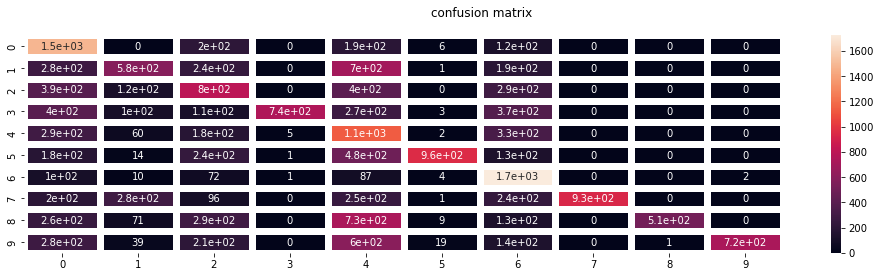

In [6]:
model.load_state_dict(torch.load("models/07_Hoda_SadigAli_Adam_20_epochs.pth"))
model.to(device)
eval(model,nn.CrossEntropyLoss(),test_loader,device)